🎵 Found 1440 audio files.
📊 Class distribution:
angry     : 50
calm      : 50
disgust   : 50
fearful   : 50
happy     : 50
neutral   : 50
sad       : 50
surprised : 50

✅ Final dataset: 400 samples, shape (400, 40, 216)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,224 (114.16 KB)

 Trainable params: 29,224 (114.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.0833 - loss: 2.0794 - val_accuracy: 0.1625 - val_loss: 2.0747
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.1669 - loss: 2.0721 - val_accuracy: 0.2125 - val_loss: 2.0474
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.1773 - loss: 2.0319 - val_accuracy: 0.2000 - val_loss: 2.0086
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.2105 - loss: 1.9857 - val_accuracy: 0.1375 - val_loss: 1.9414
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.1766 - loss: 1.9522 - val_accuracy: 0.1875 - val_loss: 1.9038
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.2040 - loss: 1.9062 - val_accuracy: 0.2375 - val_loss: 1.8839
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.2312 - loss: 1.8659 - val_accuracy: 0.2375 - val_loss: 1.8621
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.2458 - loss: 1.7905 - val_accuracy: 0.2000 - 

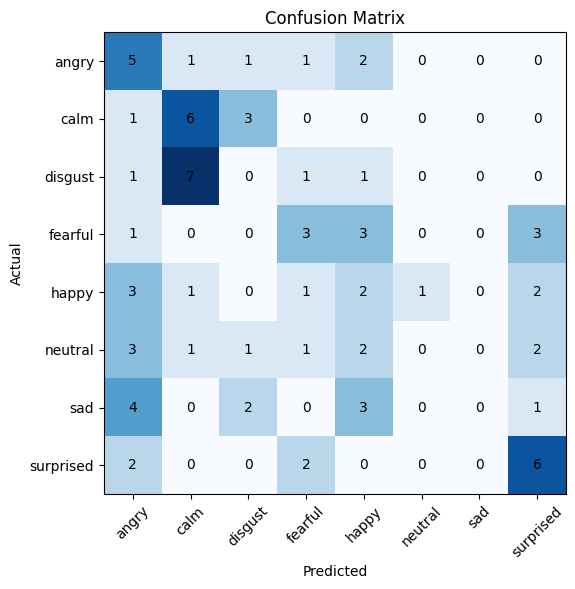

In [1]:
# ============================================
# FINAL TASK 2 - Light Version (Colab-Safe)
# ============================================

!pip install -q resampy librosa soundfile scikit-learn matplotlib tensorflow

import os, zipfile, glob, warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ----------------------------
# 1) Download & extract RAVDESS
# ----------------------------
RAVDESS_URL = "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1"
RAVDESS_ZIP = "ravdess_speech.zip"
EXTRACT_DIR = "ravdess_speech"

if not os.path.exists(EXTRACT_DIR):
    print("📥 Downloading RAVDESS dataset...")
    !wget -q -O $RAVDESS_ZIP $RAVDESS_URL
    with zipfile.ZipFile(RAVDESS_ZIP, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)

wav_files = sorted(glob.glob(os.path.join(EXTRACT_DIR, "Actor_*", "*.wav")))
print(f"🎵 Found {len(wav_files)} audio files.")

# ----------------------------
# 2) Emotion mapping
# ----------------------------
emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

def emotion_from_filename(fname):
    em_code = os.path.basename(fname).split("-")[2]
    return emotion_map.get(em_code)

# Limit samples for stability
PER_CLASS_LIMIT = 50
files_by_label = {}
for f in wav_files:
    label = emotion_from_filename(f)
    files_by_label.setdefault(label, []).append(f)

selected_files = []
for label, files in files_by_label.items():
    selected_files.extend(files[:PER_CLASS_LIMIT])

print("📊 Class distribution:")
for label in sorted(files_by_label.keys()):
    count = sum(1 for f in selected_files if emotion_from_filename(f) == label)
    print(f"{label:10s}: {count}")

# ----------------------------
# 3) Feature extraction (MFCC)
# ----------------------------
N_MFCC = 40
MAX_PAD_LEN = 216
SR = 22050

def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=SR, res_type="kaiser_fast")
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    if mfcc.shape[1] < MAX_PAD_LEN:
        mfcc = np.pad(mfcc, ((0, 0), (0, MAX_PAD_LEN - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :MAX_PAD_LEN]
    return mfcc

X_list, y_list = [], []
for f in selected_files:
    mfcc = extract_mfcc(f)
    X_list.append(mfcc)
    y_list.append(emotion_from_filename(f))

X = np.array(X_list, dtype=np.float32)
labels = np.array(y_list)
print(f"\n✅ Final dataset: {X.shape[0]} samples, shape {X.shape}")

# Transpose to (samples, frames, mfcc)
X = X.transpose(0, 2, 1)

# Encode labels
le = LabelEncoder()
y_int = le.fit_transform(labels)
y = tf.keras.utils.to_categorical(y_int, num_classes=len(le.classes_))

# ----------------------------
# 4) Train/Test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_int
)

# ----------------------------
# 5) LSTM Model
# ----------------------------
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(len(le.classes_), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=10, batch_size=16, verbose=1)

# ----------------------------
# 6) Evaluation
# ----------------------------
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.xticks(range(len(le.classes_)), le.classes_, rotation=45)
plt.yticks(range(len(le.classes_)), le.classes_)
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, str(val), ha='center', va='center')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
